In [1]:
import sys
%load_ext autoreload
%autoreload 2

%cd edm
from torch_utils import misc
from dnnlib import util
from fid import calculate_inception_stats, calculate_fid_from_inception_stats
%cd ..

/home/jupyter/project/edm
/home/jupyter/project


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dict_keys(['step', 'clean_latents', 'true_latents', 'fake_latents', 'condition'])
Step: 5000
Fake latents shape: torch.Size([128, 3, 32, 32])


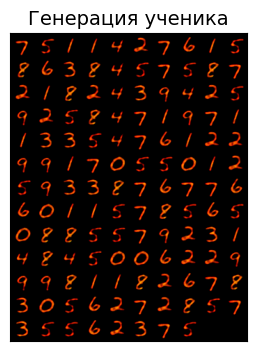

Condition labels: tensor([7, 5, 1, 1, 4, 2, 7, 6, 1, 5, 8, 6, 3, 8, 4, 5, 7, 5, 8, 7, 2, 1, 8, 2,
        4, 3, 9, 4, 2, 5, 9, 2, 5, 8, 4, 7, 1, 9, 7, 1, 1, 3, 3, 5, 4, 7, 6, 1,
        2, 2, 9, 9, 1, 7, 0, 5, 5, 0, 1, 2, 5, 9, 3, 3, 8, 7, 6, 7, 7, 6, 6, 0,
        1, 1, 5, 7, 8, 5, 6, 5, 0, 8, 8, 5, 5, 7, 9, 2, 3, 1, 4, 8, 4, 5, 0, 0,
        6, 2, 2, 9, 9, 9, 8, 1, 1, 8, 2, 6, 7, 8, 3, 0, 5, 6, 2, 7, 2, 8, 5, 7,
        3, 5, 5, 6, 2, 3, 7, 5])


In [29]:
from dataset import GeneratedDistillationDataset
from models import EDMPrecond
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import pickle
import torch.nn as nn
import torch
import os

def remove_ticks(ax):
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False,
        left=False,
        labelleft=False
    )

def remove_xticks(ax):
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False,
        left=True,
        labelleft=True
    )

def visualize_batch(img_vis, title='Генерация ученика', nrow=10, ncol=4):
    img_grid = make_grid(img_vis, nrow=nrow)
    fig, ax = plt.subplots(1, figsize=(nrow, ncol))
    remove_ticks(ax)
    ax.set_title(title, fontsize=14)
    ax.imshow(img_grid.permute(1, 2, 0))
    plt.savefig("exp3/fake.png", dpi=300, bbox_inches="tight")
    plt.show()
    
def visualize_latent(sample):
    """Визуализирует один латентный тензор (3, H, W) как RGB картинку."""
    latents = sample["latents"].cpu()
    img = latents.permute(1, 2, 0).numpy()  # (H, W, C)
    img = (img - img.min()) / (img.max() - img.min())  # нормализуем 0-1

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Sample Latent Visualization")
    plt.show()

def show_fake(step):  
    file_path = f"logs/latents_exp3/latents_step_{step}.pt"
    if not os.path.exists(file_path):
        print(f"Файл не найден!")
        return

    data = torch.load(file_path)
    print(data.keys())
    fake_latents = data["fake_latents"]
    condition = data.get("condition", None)

    print(f"Step: {data['step']}")
    print(f"Fake latents shape: {fake_latents.shape}")
    visualize_batch(fake_latents)

    if condition is not None:
        if condition.ndim == 2:
            labels = torch.argmax(condition, dim=1)
        else:
            labels = condition
        print("Condition labels:", labels)


show_fake(5000)

In [ ]:
# ls -lt checkpoints/

total 10034217
-rw------- 1 jupyter jupyter 312200263 Dec 21 15:53 last-v6.ckpt
-rw------- 1 jupyter jupyter 312200263 Dec 21 15:43 ladd-step=0019000-train_loss_g=0.0000.ckpt
-rw------- 1 jupyter jupyter 312200263 Dec 21 15:33 ladd-step=0018000-train_loss_g=0.0000.ckpt
-rw------- 1 jupyter jupyter 312200263 Dec 21 15:22 ladd-step=0017000-train_loss_g=0.0000.ckpt
-rw------- 1 jupyter jupyter 180158464 Dec 21 11:46 last-v5.ckpt
-rw------- 1 jupyter jupyter 312200327 Dec 21 11:37 ladd-step=0004000-train_loss_g=0.0000-v2.ckpt
-rw------- 1 jupyter jupyter 312200199 Dec 21 11:19 ladd-step=0002000-train_loss_g=0.0000-v4.ckpt
-rw------- 1 jupyter jupyter 312199817 Dec 21 11:11 ladd-step=0001000-train_loss_g=0.0000-v5.ckpt
-rw------- 1 jupyter jupyter 342466503 Dec 21 10:54 last-v4.ckpt
-rw------- 1 jupyter jupyter 342466503 Dec 21 10:53 ladd-step=0003000-train_loss_g=0.0000-v2.ckpt
-rw------- 1 jupyter jupyter 342466375 Dec 21 10:44 ladd-step=0002000-train_loss_g=0.0000-v3.ckpt
-rw------- 1 ju

# FID calculations

In [4]:
# import lightning
# from train_utils import LADDDistillationModule
# from utils import load_config

# config = load_config("config.yaml")
# cond_model = EDMPrecond(
#         img_resolution=32, 
#         img_channels=3, 
#         model_type='CUNet', 
#         noise_channels=128, 
#         base_factor=64, 
#         emb_channels=128, 
#         label_dim=11
#     )
# module = LADDDistillationModule.load_from_checkpoint("exp_big_disc_50k/checkpoints/ladd-step=0006000-train_loss_g=0.0000.ckpt", cond_model, config["ladd"])

checkpoint =  checkpoint = torch.load(
    "checkpoints/last-v6.ckpt",
    map_location='cpu'
)

In [5]:
state_dict = checkpoint["state_dict"]

student_state_dict = {
    k.replace('student.', ''): v 
    for k, v in state_dict.items() 
    if k.startswith('student.')
}

In [8]:
import os, shutil
from tqdm import tqdm
from dataset import sample_euler
from PIL import Image
import numpy as np

def save_model_samples(name, model, params, batch_size, num_samples, labels_usage='uniform', **model_kwargs):
    if os.path.exists(name):
        shutil.rmtree(name) # перед сохранением изображений в папку папка очищается
    os.makedirs(name, exist_ok=True) # и пересоздается
    count = 0

    assert num_samples % 10 == 0

    with tqdm(total= num_samples) as pbar:
        while count < num_samples:
            cur_batch_size = min(num_samples - count, batch_size)
            noise = torch.randn(cur_batch_size, 3, 32, 32, device=params['device'])
            if labels_usage == 'dummy':
                labels = torch.zeros(cur_batch_size, 11, device=params['device'])
                labels[:, -1] = 1
            elif labels_usage == 'uniform':
                idxs = torch.arange(count, count + cur_batch_size, device=params['device'])
                labels = idxs // (num_samples / 10)
                labels = (labels[:, None] == torch.arange(11, device=labels.device)[None, :]).float()
            else:
                raise NotImplementedError

            out, trajectory = sample_euler(model, noise, params, class_labels=labels, **model_kwargs)
            out = (out * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()
            for i in range(out.shape[0]):
                img = Image.fromarray(out[i])
                n_digits = len(str(count))
                img_name = (6 - n_digits) * '0' + str(count) + '.png'
                img.save(os.path.join(name, img_name))
                count += 1
                pbar.update(1)
                pbar.set_description('%d images saved' % (count,))

def calc_fid(image_path, ref_path, num_expected, batch):
    with util.open_url(ref_path) as f:
        ref = dict(np.load(f))

    mu, sigma = calculate_inception_stats(image_path=image_path, num_expected=num_expected, max_batch_size=batch)
    fid = calculate_fid_from_inception_stats(mu, sigma, ref['mu'], ref['sigma'])
    return fid



sampling_params = {
    'device': 'cuda',
    'sigma_min': 0.002,
    'sigma_max': 80.0,
    'num_steps': 50,
    'rho': 7.0,
    'vis_steps': 1,
    'stochastic': False,
    'cfg': 0.0,
    'iter_start': 0,
    'iter_end': 10000,
}

# cond model
cond_model = EDMPrecond(
    img_resolution=32, 
    img_channels=3, 
    model_type='CUNet', 
    noise_channels=128, 
    base_factor=64, 
    emb_channels=128, 
    label_dim=11
).to(sampling_params["device"])
cond_model.load_state_dict(torch.load("weights_and_dataset/EDMPrecond_base.pt"))
cond_model.eval()

ladd_model = EDMPrecond(
    img_resolution=32, 
    img_channels=3, 
    model_type='CUNet', 
    noise_channels=128, 
    base_factor=64, 
    emb_channels=128, 
    label_dim=11
).to(sampling_params["device"])
ladd_model.load_state_dict(student_state_dict)
ladd_model.eval()

save_model_samples('cunet_cond_samples', cond_model, sampling_params, batch_size=512, num_samples=3000, labels_usage='uniform')
fid = calc_fid('cunet_cond_samples', 'cmnist_train.npz', num_expected=3000, batch=512)
print("FID for default CUnet is ", fid)
# save_model_samples('ladd_cond_samples', ladd_model, sampling_params, batch_size=512, num_samples=3000, labels_usage='uniform')
# fid = calc_fid('ladd_cond_samples', 'cmnist_train.npz', num_expected=3000, batch=512)
# print("FID for distilled CUnet is ", fid)


3000 images saved: 100%|██████████| 3000/3000 [01:37<00:00, 30.87it/s] 


Loading Inception-v3 model...
Loading images from "cunet_cond_samples"...
Calculating statistics for 3000 images...


100%|██████████| 6/6 [00:12<00:00,  2.01s/batch]


FID for default CUnet is  3.6607934676329217
